# Predict Bike Sharing Demand with AutoGluon 

## Step 1: Create an account with Kaggle

## Step 2: Download the Kaggle dataset using the kaggle python library

### Install packages

In [ ]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir
# Without --no-cache-dir, smaller aws instances may have trouble installing

### Setup Kaggle API Key

In [1]:
# create the .kaggle directory and an empty kaggle.json file
!mkdir -p ~/.kaggle
!touch ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
# Fill in your user name and key from creating the kaggle account and API token file
import json
import os
kaggle_username = "bhagyasriu"
kaggle_key = "e11a98a51fd366cf3286ebd8af5b50c1"

# Get the absolute path to the user's home directory
home_dir = os.path.expanduser("~")
kaggle_file_path = os.path.join(home_dir, ".kaggle/kaggle.json")

# Save API token the kaggle.json file
with open(kaggle_file_path, "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

### Download and explore dataset

In [ ]:
# Download the dataset, it will be in a .zip file so you'll need to unzip it as well.
!kaggle competitions download -c bike-sharing-demand
# If you already downloaded it you can use the -o command to overwrite the file


In [ ]:
!unzip -o bike-sharing-demand.zip

In [3]:
import pandas as pd
from autogluon.tabular import TabularPredictor

In [4]:
# Create the train dataset in pandas by reading the csv
# Setting the parsing of the datetime column to use some of the `dt` features in pandas later
train = pd.read_csv("train.csv", parse_dates=["datetime"])
train.head()

datetime  season  holiday  workingday  weather  temp   atemp  \
0 2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1 2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2 2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
3 2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
4 2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  casual  registered  count  
0        81        0.0       3          13     16  
1        80        0.0       8          32     40  
2        80        0.0       5          27     32  
3        75        0.0       3          10     13  
4        75        0.0       0           1      1

In [5]:
# Simple output of the train dataset to view some of the min/max/varition of the dataset features.
train.describe()

season       holiday    workingday       weather         temp  \
count  10886.000000  10886.000000  10886.000000  10886.000000  10886.00000   
mean       2.506614      0.028569      0.680875      1.418427     20.23086   
std        1.116174      0.166599      0.466159      0.633839      7.79159   
min        1.000000      0.000000      0.000000      1.000000      0.82000   
25%        2.000000      0.000000      0.000000      1.000000     13.94000   
50%        3.000000      0.000000      1.000000      1.000000     20.50000   
75%        4.000000      0.000000      1.000000      2.000000     26.24000   
max        4.000000      1.000000      1.000000      4.000000     41.00000   

              atemp      humidity     windspeed        casual    registered  \
count  10886.000000  10886.000000  10886.000000  10886.000000  10886.000000   
mean      23.655084     61.886460     12.799395     36.021955    155.552177   
std        8.474601     19.245033      8.164537     49.960477    151.039033   
min        0.760000      0.000000      0.000000      0.000000      0.000000   
25%       16.665000     47.000000      7.001500      4.000000     36.000000   
50%       24.240000     62.000000     12.998000     17.000000    118.000000   
75%       31.060000     77.000000     16.997900     49.000000    222.000000   
max       45.455000    100.000000     56.996900    367.000000    886.000000   

              count  
count  10886.000000  
mean     191.574132  
std      181.144454  
min        1.000000  
25%       42.000000  
50%      145.000000  
75%      284.000000  
max      977.000000

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [7]:
# Create the test pandas dataframe in pandas by reading the csv, parse the datetime column
test = pd.read_csv("test.csv", parse_dates=["datetime"])
test.head()

datetime  season  holiday  workingday  weather   temp   atemp  \
0 2011-01-20 00:00:00       1        0           1        1  10.66  11.365   
1 2011-01-20 01:00:00       1        0           1        1  10.66  13.635   
2 2011-01-20 02:00:00       1        0           1        1  10.66  13.635   
3 2011-01-20 03:00:00       1        0           1        1  10.66  12.880   
4 2011-01-20 04:00:00       1        0           1        1  10.66  12.880   

   humidity  windspeed  
0        56    26.0027  
1        56     0.0000  
2        56     0.0000  
3        56    11.0014  
4        56    11.0014

In [8]:
# Same thing as train and test dataset
submission = pd.read_csv("sampleSubmission.csv", parse_dates=["datetime"])
submission.head()

datetime  count
0 2011-01-20 00:00:00      0
1 2011-01-20 01:00:00      0
2 2011-01-20 02:00:00      0
3 2011-01-20 03:00:00      0
4 2011-01-20 04:00:00      0

## Step 3: Train a model using AutoGluon’s Tabular Prediction

Requirements:
* Predicting `count`, so that is the label.
* Ignore `casual` and `registered` columns as they are also not present in the test dataset. 
* Use the `root_mean_squared_error` as the metric to use for evaluation.
* Set a time limit of 10 minutes (600 seconds).
* Use the preset `best_quality` to focus on creating the best model.

In [9]:
predictor = TabularPredictor(label='count', eval_metric='root_mean_squared_error', problem_type='regression', learner_kwargs={'ignored_columns':["casual", "registered"]}).fit(train_data=train, presets='best_quality', time_limit=600)

No path specified. Models will be saved in: "AutogluonModels/ag-20230530_214028/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20230530_214028/"
AutoGluon Version:  0.7.0
Python Version:     3.9.16
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.6.0: Mon May  8 23:12:01 PDT 2023; root:xnu-8796.140.12.505.1~5/RELEASE_ARM64_T8112
Train Data Rows:    10886
Train Data Columns: 11
Label Column: count
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Dropping user-specified ignored columns: ['casual', 'registered']
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    1856.8 MB
	Train Data (Original)  Memory Usage: 0.78 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Se

[1000]	valid_set's rmse: 131.684
[2000]	valid_set's rmse: 130.67
[3000]	valid_set's rmse: 130.626
[1000]	valid_set's rmse: 135.592
[1000]	valid_set's rmse: 133.481
[2000]	valid_set's rmse: 132.323
[3000]	valid_set's rmse: 131.618
[4000]	valid_set's rmse: 131.443
[5000]	valid_set's rmse: 131.265
[6000]	valid_set's rmse: 131.277
[7000]	valid_set's rmse: 131.443
[1000]	valid_set's rmse: 128.503
[2000]	valid_set's rmse: 127.654
[3000]	valid_set's rmse: 127.227
[4000]	valid_set's rmse: 127.105
[1000]	valid_set's rmse: 134.135
[2000]	valid_set's rmse: 132.272
[3000]	valid_set's rmse: 131.286
[4000]	valid_set's rmse: 130.752
[5000]	valid_set's rmse: 130.363
[6000]	valid_set's rmse: 130.509
[1000]	valid_set's rmse: 136.168
[2000]	valid_set's rmse: 135.138
[3000]	valid_set's rmse: 135.029
[1000]	valid_set's rmse: 134.061
[2000]	valid_set's rmse: 133.034
[3000]	valid_set's rmse: 132.182
[4000]	valid_set's rmse: 131.997
[5000]	valid_set's rmse: 131.643
[6000]	valid_set's rmse: 131.504
[7000]	vali

	-131.4609	 = Validation score   (-root_mean_squared_error)
	264.08s	 = Training   runtime
	1.66s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 130.22s of the 330.28s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's rmse: 130.818
[1000]	valid_set's rmse: 133.204
[1000]	valid_set's rmse: 130.928
[1000]	valid_set's rmse: 126.846
[1000]	valid_set's rmse: 131.426
[1000]	valid_set's rmse: 133.655
[1000]	valid_set's rmse: 132.155
[1000]	valid_set's rmse: 130.62


	-131.0542	 = Validation score   (-root_mean_squared_error)
	63.19s	 = Training   runtime
	0.22s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L1 ... Training model for up to 66.25s of the 266.32s of remaining time.
	-116.5439	 = Validation score   (-root_mean_squared_error)
	3.87s	 = Training   runtime
	0.41s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ... Training model for up to 61.67s of the 261.73s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 2177.
	Ran out of time, early stopping on iteration 2081.
	Ran out of time, early stopping on iteration 2301.
	Ran out of time, early stopping on iteration 2361.
	Ran out of time, early stopping on iteration 2469.
	Ran out of time, early stopping on iteration 2580.
	Ran out of time, early stopping on iteration 2643.
	Ran out of time, early stopping on iteration 3180.
	-131.071	 = Validation score   (-root_mean_square

[1000]	valid_set's rmse: 61.0983
[2000]	valid_set's rmse: 60.039
[1000]	valid_set's rmse: 61.6472
[2000]	valid_set's rmse: 60.6071
[1000]	valid_set's rmse: 63.3046
[2000]	valid_set's rmse: 62.1028
[1000]	valid_set's rmse: 63.2228
[2000]	valid_set's rmse: 61.61
[1000]	valid_set's rmse: 58.5778
[2000]	valid_set's rmse: 57.9293
[1000]	valid_set's rmse: 62.9802
[2000]	valid_set's rmse: 61.6608
[1000]	valid_set's rmse: 64.154
[2000]	valid_set's rmse: 63.4231
[3000]	valid_set's rmse: 63.3403
[1000]	valid_set's rmse: 58.5102
[2000]	valid_set's rmse: 58.196


	-60.6309	 = Validation score   (-root_mean_squared_error)
	146.53s	 = Training   runtime
	0.93s	 = Validation runtime
Fitting model: LightGBM_BAG_L2 ... Training model for up to 50.81s of the 50.8s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-54.7054	 = Validation score   (-root_mean_squared_error)
	28.59s	 = Training   runtime
	0.07s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L2 ... Training model for up to 22.04s of the 22.03s of remaining time.
	-53.2672	 = Validation score   (-root_mean_squared_error)
	9.51s	 = Training   runtime
	0.45s	 = Validation runtime
Fitting model: CatBoost_BAG_L2 ... Training model for up to 11.75s of the 11.74s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 426.
	Ran out of time, early stopping on iteration 351.
	Ran out of time, early stopping on iteration 386.
	Ran out of

### Review AutoGluon's training run with ranking of models that did the best.

In [10]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -52.688021       3.770454  433.922582                0.000629           0.177524            3       True         14
1   RandomForestMSE_BAG_L2  -53.267158       3.249030  401.832398                0.452846           9.506915            2       True         11
2     ExtraTreesMSE_BAG_L2  -53.784318       3.250063  395.645347                0.453879           3.319864            2       True         13
3          LightGBM_BAG_L2  -54.705436       2.863100  420.918279                0.066916          28.592796            2       True         10
4          CatBoost_BAG_L2  -57.243068       2.846518  403.549066                0.050334          11.223583            2       True         12
5        LightGBMXT_BAG_L2  -60.630950       3.726283  538.859477         

/Users/Q/opt/anaconda3/envs/ml/lib/python3.9/site-packages/autogluon/core/utils/plots.py:138: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.58817625927213,
  'KNeighborsDist_BAG_L1': -84.14642264302962,
  'LightGBMXT_BAG_L1': -131.46090891834504,
  'LightGBM_BAG_L1': -131.054161598899,
  'RandomForestMSE_BAG_L1': -116.54389626190594,
 

### Create predictions from test dataset

In [11]:
predictions = predictor.predict(test)
predictions.head()

0    24.277527
1    41.242107
2    46.853897
3    49.254997
4    51.276726
Name: count, dtype: float32

#### NOTE: Kaggle will reject the submission if everything isn't > 0.

In [12]:
# Describe the `predictions` series to see if there are any negative values
predictions.describe()

count    6493.000000
mean      100.547165
std        89.905022
min         3.275379
25%        20.669958
50%        64.054520
75%       170.723083
max       367.125702
Name: count, dtype: float64

### There are no negative values in the predictions series, so we can use it to create the submission file

In [13]:
# How many negative values do we have?
(predictions < 0).sum()

0

In [14]:
# Set them to zero
predictions[predictions < 0] = 0

### Set predictions to submission dataframe, save, and submit

In [ ]:
submission["count"] = predictions
submission.to_csv("submission.csv", index=False)

In [16]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"

100%|████████████████████████████████████████| 188k/188k [00:03<00:00, 59.8kB/s]
Successfully submitted to Bike Sharing Demand

#### View submission via the command line or in the web browser under the competition's page - `My Submissions`

In [17]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName        date                 description           status    publicScore  privateScore  
--------------  -------------------  --------------------  --------  -----------  ------------  
submission.csv  2023-05-30 21:50:54  first raw submission  complete  1.80025      1.80025       


#### Initial score of `1.80`

## Step 4: Exploratory Data Analysis and Creating an additional feature

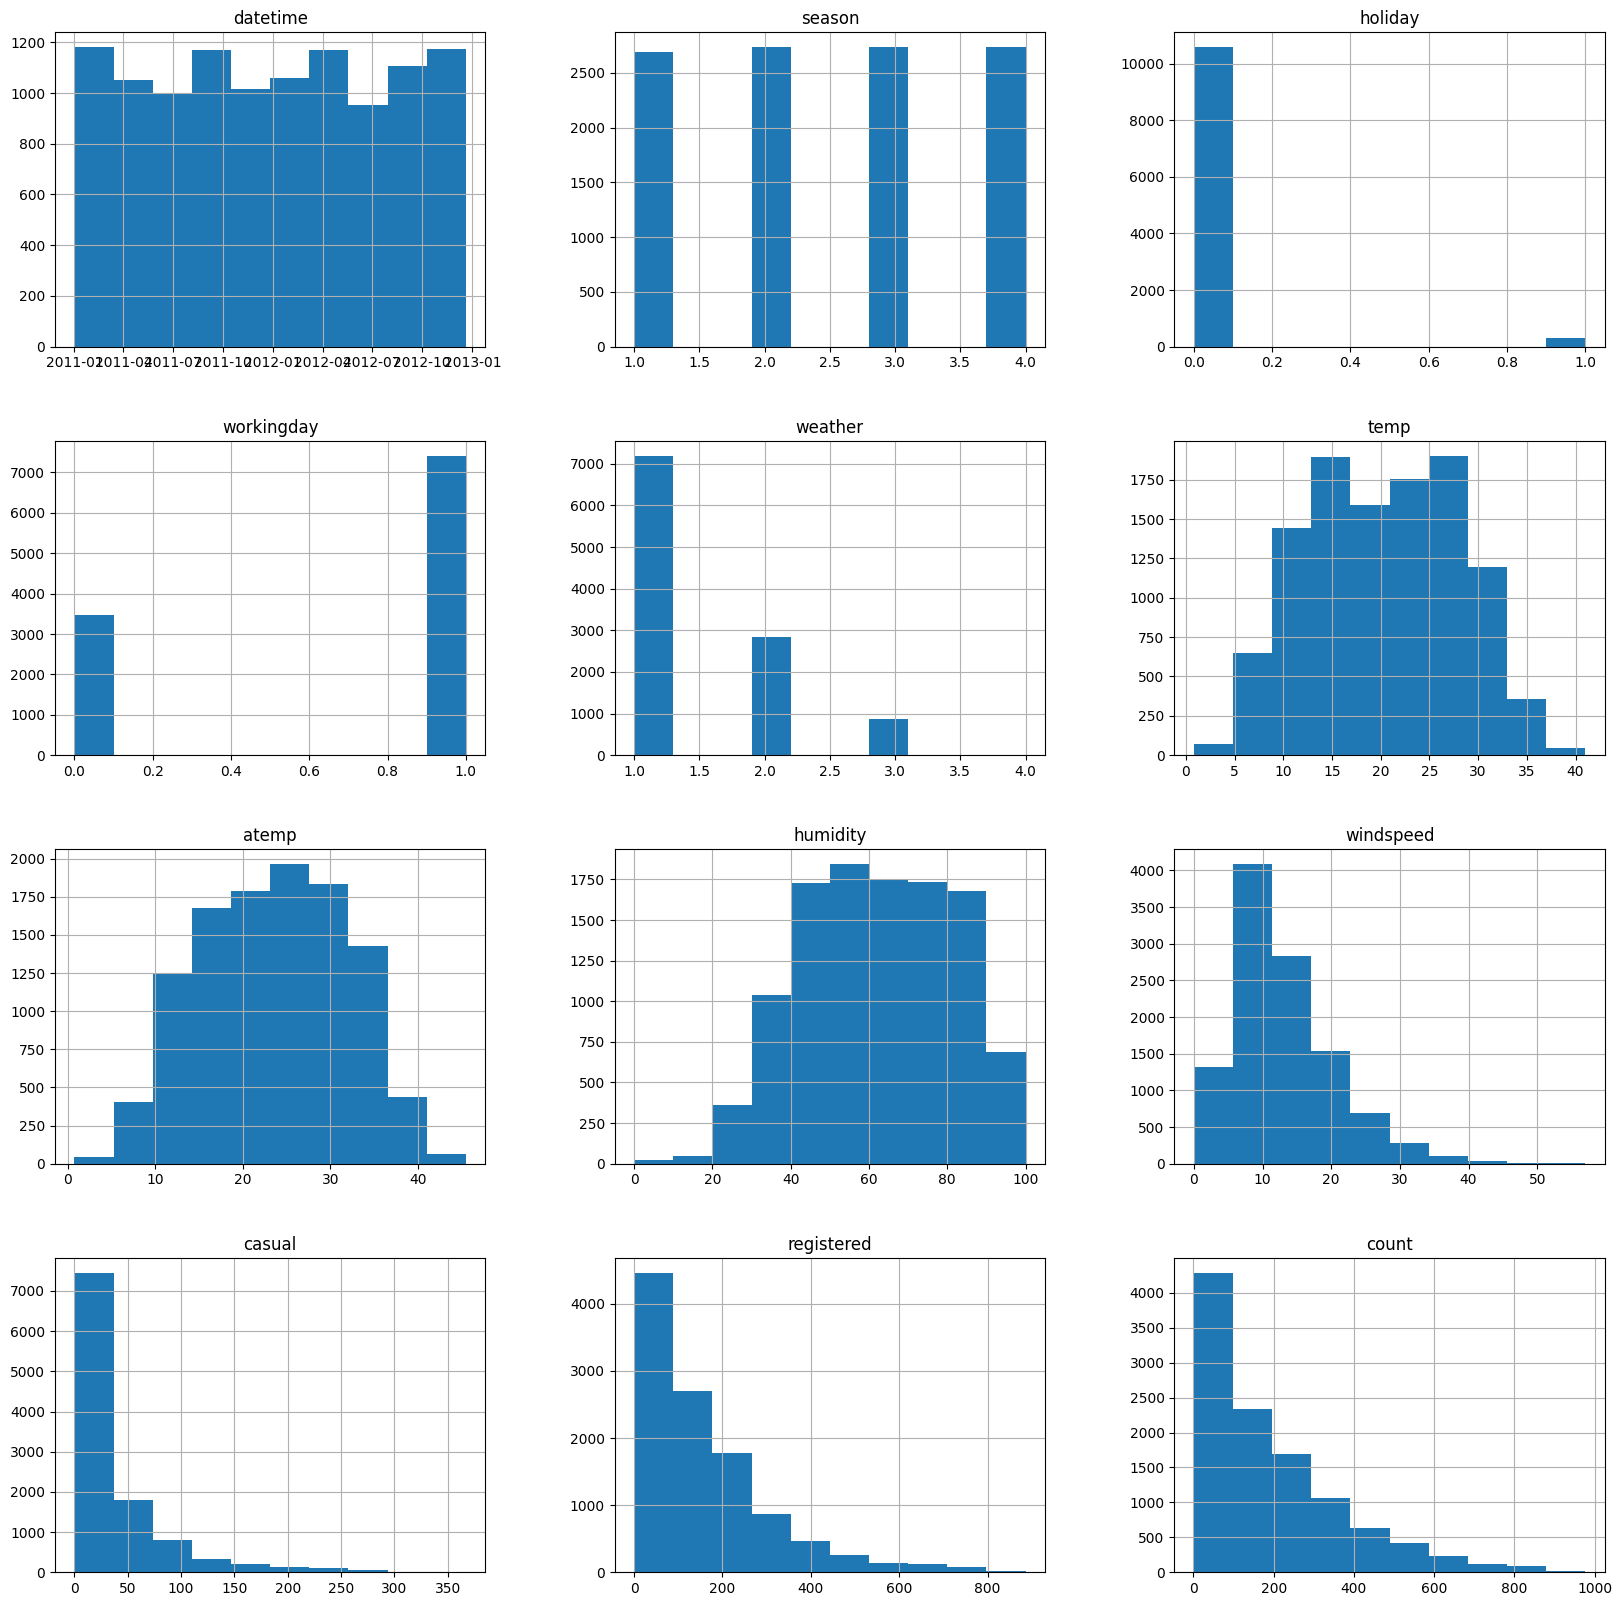

In [18]:
# Create a histogram of all features to show the distribution of each one relative to the data. This is part of the exploritory data analysis
train.hist(figsize=(20, 20));

In [19]:
# create a new feature
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour

test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['day'] = test['datetime'].dt.day
test['hour'] = test['datetime'].dt.hour

## Make category types for these so models know they are not just numbers
* AutoGluon originally sees these as ints, but in reality they are int representations of a category.
* Setting the dtype to category will classify these as categories in AutoGluon.

In [20]:
train["season"] = train["season"].astype("category")
train["weather"] = train["weather"].astype("category")
test["season"] = test["season"].astype("category")
test["weather"] = test["weather"].astype("category")

In [21]:
train.corr()

/var/folders/qx/npbndsjn5_dfgg0qm8qhk2s00000gn/T/ipykernel_8681/2189804198.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train.corr()


holiday  workingday      temp     atemp  humidity  windspeed  \
holiday     1.000000   -0.250491  0.000295 -0.005215  0.001929   0.008409   
workingday -0.250491    1.000000  0.029966  0.024660 -0.010880   0.013373   
temp        0.000295    0.029966  1.000000  0.984948 -0.064949  -0.017852   
atemp      -0.005215    0.024660  0.984948  1.000000 -0.043536  -0.057473   
humidity    0.001929   -0.010880 -0.064949 -0.043536  1.000000  -0.318607   
windspeed   0.008409    0.013373 -0.017852 -0.057473 -0.318607   1.000000   
casual      0.043799   -0.319111  0.467097  0.462067 -0.348187   0.092276   
registered -0.020956    0.119460  0.318571  0.314635 -0.265458   0.091052   
count      -0.005393    0.011594  0.394454  0.389784 -0.317371   0.101369   
year        0.012021   -0.002482  0.061226  0.058540 -0.078606  -0.015221   
month       0.001731   -0.003394  0.257589  0.264173  0.204537  -0.150192   
day        -0.015877    0.009829  0.015551  0.011866 -0.011335   0.036157   
hour       -0.000354    0.002780  0.145430  0.140343 -0.278011   0.146631   

              casual  registered     count      year     month       day  \
holiday     0.043799   -0.020956 -0.005393  0.012021  0.001731 -0.015877   
workingday -0.319111    0.119460  0.011594 -0.002482 -0.003394  0.009829   
temp        0.467097    0.318571  0.394454  0.061226  0.257589  0.015551   
atemp       0.462067    0.314635  0.389784  0.058540  0.264173  0.011866   
humidity   -0.348187   -0.265458 -0.317371 -0.078606  0.204537 -0.011335   
windspeed   0.092276    0.091052  0.101369 -0.015221 -0.150192  0.036157   
casual      1.000000    0.497250  0.690414  0.145241  0.092722  0.014109   
registered  0.497250    1.000000  0.970948  0.264265  0.169451  0.019111   
count       0.690414    0.970948  1.000000  0.260403  0.166862  0.019826   
year        0.145241    0.264265  0.260403  1.000000 -0.004932  0.001800   
month       0.092722    0.169451  0.166862 -0.004932  1.000000  0.001974   
day         0.014109    0.019111  0.019826  0.001800  0.001974  1.000000   
hour        0.302045    0.380540  0.400601 -0.004234 -0.006818  0.001132   

                hour  
holiday    -0.000354  
workingday  0.002780  
temp        0.145430  
atemp       0.140343  
humidity   -0.278011  
windspeed   0.146631  
casual      0.302045  
registered  0.380540  
count       0.400601  
year       -0.004234  
month      -0.006818  
day         0.001132  
hour        1.000000

In [22]:
# Drop highly correlated features
train.drop('atemp', axis=1, inplace=True)
test.drop('atemp', axis=1, inplace=True)

In [23]:
# View are new feature
train.head()

datetime season  holiday  workingday weather  temp  humidity  \
0 2011-01-01 00:00:00      1        0           0       1  9.84        81   
1 2011-01-01 01:00:00      1        0           0       1  9.02        80   
2 2011-01-01 02:00:00      1        0           0       1  9.02        80   
3 2011-01-01 03:00:00      1        0           0       1  9.84        75   
4 2011-01-01 04:00:00      1        0           0       1  9.84        75   

   windspeed  casual  registered  count  year  month  day  hour  
0        0.0       3          13     16  2011      1    1     0  
1        0.0       8          32     40  2011      1    1     1  
2        0.0       5          27     32  2011      1    1     2  
3        0.0       3          10     13  2011      1    1     3  
4        0.0       0           1      1  2011      1    1     4

In [24]:
# View histogram of all features again now with the new features
train.hist(figsize=(20, 20));

In [25]:
# Add feature 'day_type' to the dataset
train["day_type"]=""
train.loc[(train.holiday==1),"day_type"] = "holiday"
train.loc[((train.holiday==0) & (train.workingday==1)), "day_type"] = "weekday"
train.loc[((train.holiday==0) & (train.workingday==0)), "day_type"] = "weekend"

test["day_type"]=""
test.loc[(test.holiday==1),"day_type"] = "holiday"
test.loc[((test.holiday==0) & (test.workingday==1)), "day_type"] = "weekday"
test.loc[((test.holiday==0) & (test.workingday==0)), "day_type"] = "weekend"

train["day_type"] = train["day_type"].astype("category")
test["day_type"] = test["day_type"].astype("category")

In [26]:
train.head()

datetime season  holiday  workingday weather  temp  humidity  \
0 2011-01-01 00:00:00      1        0           0       1  9.84        81   
1 2011-01-01 01:00:00      1        0           0       1  9.02        80   
2 2011-01-01 02:00:00      1        0           0       1  9.02        80   
3 2011-01-01 03:00:00      1        0           0       1  9.84        75   
4 2011-01-01 04:00:00      1        0           0       1  9.84        75   

   windspeed  casual  registered  count  year  month  day  hour day_type  
0        0.0       3          13     16  2011      1    1     0  weekend  
1        0.0       8          32     40  2011      1    1     1  weekend  
2        0.0       5          27     32  2011      1    1     2  weekend  
3        0.0       3          10     13  2011      1    1     3  weekend  
4        0.0       0           1      1  2011      1    1     4  weekend

## Step 5: Rerun the model with the same settings as before, just with more features

In [27]:
predictor_new_features = TabularPredictor(label='count', eval_metric='root_mean_squared_error', problem_type='regression', learner_kwargs={'ignored_columns':["casual", "registered"]}).fit(train_data=train, presets='best_quality', time_limit=600)

No path specified. Models will be saved in: "AutogluonModels/ag-20230530_215100/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20230530_215100/"
AutoGluon Version:  0.7.0
Python Version:     3.9.16
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.6.0: Mon May  8 23:12:01 PDT 2023; root:xnu-8796.140.12.505.1~5/RELEASE_ARM64_T8112
Train Data Rows:    10886
Train Data Columns: 15
Label Column: count
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Dropping user-specified ignored columns: ['casual', 'registered']
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    1854.16 MB
	Train Data (Original)  Memory Usage: 0.9 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Se

[1000]	valid_set's rmse: 35.532
[2000]	valid_set's rmse: 33.7781
[3000]	valid_set's rmse: 33.4653
[4000]	valid_set's rmse: 33.4158
[5000]	valid_set's rmse: 33.4367
[1000]	valid_set's rmse: 36.9302
[2000]	valid_set's rmse: 34.9906
[3000]	valid_set's rmse: 34.4646
[4000]	valid_set's rmse: 34.3891
[5000]	valid_set's rmse: 34.4072


	Ran out of time, early stopping on iteration 5506. Best iteration is:
	[5246]	valid_set's rmse: 34.3684


[1000]	valid_set's rmse: 36.0733
[2000]	valid_set's rmse: 34.1783
[3000]	valid_set's rmse: 33.7763
[4000]	valid_set's rmse: 33.5457
[5000]	valid_set's rmse: 33.461


	Ran out of time, early stopping on iteration 5903. Best iteration is:
	[5828]	valid_set's rmse: 33.4179


[1000]	valid_set's rmse: 39.138
[2000]	valid_set's rmse: 36.9085
[3000]	valid_set's rmse: 36.5597
[4000]	valid_set's rmse: 36.3795
[5000]	valid_set's rmse: 36.3249
[6000]	valid_set's rmse: 36.3368
[1000]	valid_set's rmse: 39.5191
[2000]	valid_set's rmse: 37.5435
[3000]	valid_set's rmse: 37.0533
[4000]	valid_set's rmse: 36.9119
[5000]	valid_set's rmse: 36.7928
[6000]	valid_set's rmse: 36.83
[7000]	valid_set's rmse: 36.8282
[1000]	valid_set's rmse: 36.6318
[2000]	valid_set's rmse: 33.6337
[3000]	valid_set's rmse: 32.8724
[4000]	valid_set's rmse: 32.5906
[5000]	valid_set's rmse: 32.497
[6000]	valid_set's rmse: 32.4977
[7000]	valid_set's rmse: 32.5199
[8000]	valid_set's rmse: 32.5443
[1000]	valid_set's rmse: 38.2379
[2000]	valid_set's rmse: 37.2009
[3000]	valid_set's rmse: 36.9529
[4000]	valid_set's rmse: 36.8529
[1000]	valid_set's rmse: 35.7681
[2000]	valid_set's rmse: 33.802
[3000]	valid_set's rmse: 33.3898
[4000]	valid_set's rmse: 33.2701
[5000]	valid_set's rmse: 33.3233


	-34.6389	 = Validation score   (-root_mean_squared_error)
	315.59s	 = Training   runtime
	2.31s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 78.46s of the 278.53s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's rmse: 33.0574


	Ran out of time, early stopping on iteration 1328. Best iteration is:
	[1321]	valid_set's rmse: 32.8316


[1000]	valid_set's rmse: 32.706


	Ran out of time, early stopping on iteration 1358. Best iteration is:
	[1321]	valid_set's rmse: 32.2751


[1000]	valid_set's rmse: 32.2299


	Ran out of time, early stopping on iteration 1413. Best iteration is:
	[1410]	valid_set's rmse: 31.9004


[1000]	valid_set's rmse: 35.9168


	Ran out of time, early stopping on iteration 1470. Best iteration is:
	[1467]	valid_set's rmse: 35.4878


[1000]	valid_set's rmse: 36.258


	Ran out of time, early stopping on iteration 1530. Best iteration is:
	[1496]	valid_set's rmse: 36.0226


[1000]	valid_set's rmse: 31.2003


	Ran out of time, early stopping on iteration 1619. Best iteration is:
	[1615]	valid_set's rmse: 30.9583


[1000]	valid_set's rmse: 37.9663


	Ran out of time, early stopping on iteration 1757. Best iteration is:
	[1595]	valid_set's rmse: 37.6414


[1000]	valid_set's rmse: 35.3481
[2000]	valid_set's rmse: 35.0963


	Ran out of time, early stopping on iteration 2125. Best iteration is:
	[2037]	valid_set's rmse: 35.0738
	-34.0945	 = Validation score   (-root_mean_squared_error)
	74.42s	 = Training   runtime
	0.46s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L1 ... Training model for up to 2.63s of the 202.7s of remaining time.
	-38.163	 = Validation score   (-root_mean_squared_error)
	4.91s	 = Training   runtime
	0.42s	 = Validation runtime
Completed 1/20 k-fold bagging repeats ...
Fitting model: WeightedEnsemble_L2 ... Training model for up to 360.0s of the 197.04s of remaining time.
	-32.4584	 = Validation score   (-root_mean_squared_error)
	0.15s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting 9 L2 models ...
Fitting model: LightGBMXT_BAG_L2 ... Training model for up to 196.87s of the 196.87s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's rmse: 35.3548
[1000]	valid_set's rmse: 30.4236
[1000]	valid_set's rmse: 30.9993
[1000]	valid_set's rmse: 31.4307


	-31.5654	 = Validation score   (-root_mean_squared_error)
	50.82s	 = Training   runtime
	0.18s	 = Validation runtime
Fitting model: LightGBM_BAG_L2 ... Training model for up to 145.5s of the 145.5s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-30.636	 = Validation score   (-root_mean_squared_error)
	28.09s	 = Training   runtime
	0.08s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L2 ... Training model for up to 117.19s of the 117.19s of remaining time.
	-32.0879	 = Validation score   (-root_mean_squared_error)
	9.23s	 = Training   runtime
	0.47s	 = Validation runtime
Fitting model: CatBoost_BAG_L2 ... Training model for up to 107.2s of the 107.19s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1268.
	Ran out of time, early stopping on iteration 1221.
	Ran out of time, early stopping on iteration 1730.
	Ran o

In [28]:
predictor_new_features.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -30.266960       3.535026  574.493432                0.000371           0.196412            3       True         12
1          CatBoost_BAG_L2  -30.522012       3.280654  495.384197                0.056638         100.433733            2       True         10
2          LightGBM_BAG_L2  -30.635968       3.302034  423.043439                0.078018          28.092975            2       True          8
3        LightGBMXT_BAG_L2  -31.565371       3.399998  445.770312                0.175983          50.819848            2       True          7
4     ExtraTreesMSE_BAG_L2  -31.698793       3.702953  398.688948                0.478937           3.738484            2       True         11
5   RandomForestMSE_BAG_L2  -32.087887       3.694937  404.183618         

/Users/Q/opt/anaconda3/envs/ml/lib/python3.9/site-packages/autogluon/core/utils/plots.py:138: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.58817625927213,
  'KNeighborsDist_BAG_L1': -84.14642264302962,
  'LightGBMXT_BAG_L1': -34.638879464206475,
  'LightGBM_BAG_L1': -34.09447269431622,
  'RandomForestMSE_BAG_L1': -38.163020972186565,
  'WeightedEnsemble_L2': -32.45837255949268,
  'LightGBMXT_BAG_L2': -31.565371259965286,
  'LightGBM_BAG_L2

In [29]:
# Set all negative values to zero
predictions_new_features = predictor_new_features.predict(test)
predictions_new_features[predictions_new_features < 0] = 0

In [30]:
# Same submitting predictions
submission_new_features = pd.read_csv("sampleSubmission.csv", parse_dates=["datetime"])
submission_new_features["count"] = predictions_new_features
submission_new_features.to_csv("submission_new_features.csv", index=False)

In [31]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "new features"

100%|████████████████████████████████████████| 188k/188k [00:03<00:00, 57.1kB/s]
Successfully submitted to Bike Sharing Demand

In [32]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description           status    publicScore  privateScore  
---------------------------  -------------------  --------------------  --------  -----------  ------------  
submission_new_features.csv  2023-05-30 22:01:20  new features          complete  0.72212      0.72212       
submission.csv               2023-05-30 21:50:54  first raw submission  complete  1.80025      1.80025       


#### New Score of `0.72`

## Step 6: Hyper parameter optimization
* There are many options for hyper parameter optimization.
* Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
* The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.

In [34]:
import autogluon.core as ag
## From autogluon documentation

# Looking at the model summaries, GBM, XGB and the WeightedEnsembles have  shown good results so i'll work on those.
# GBM
gbm_options = [{'extra_trees': True, 
                'num_boost_round': ag.space.Int(lower=100, upper=800, default=100),
                'num_leaves': ag.space.Int(lower=26, upper=66, default=36),  # number of leaves in trees (integer hyperparameter)
                'ag_args': {'name_suffix': 'XT'}}, {}, 'GBMLarge']

# XGB 
xgb_options = [{'objective': 'reg:squarederror', # 'reg:linear' is deprecated
                'eval_metric': 'rmse', 
                'max_depth':ag.space.Int(lower=5, upper=9, default=7), 
                'n_estimators': ag.space.Int(lower=100, upper=500, default=100), 
                'eta':.3, 
                'subsample': 1,
                'colsample_bytree': 1}]

hyperparameters = {  
                   'GBM': gbm_options,
                   'XGB': xgb_options
                  }  

num_trials = 20            # Number of hyperparameter optimization trials you want to perform
search_strategy = 'auto'  # tune hyperparameters using Bayesian optimization routine with a local scheduler
scheduler = 'local'       # Local FIFO scheduler

hyperparameter_tune_kwargs = { 
                            'num_trials': num_trials,
                            'scheduler' : scheduler,
                            'searcher': search_strategy,
                        }

predictor_new_hpo = TabularPredictor(label='count', eval_metric='root_mean_squared_error', problem_type='regression', 
                                    learner_kwargs={'ignored_columns': ['casual', 'registered']}).fit(
                                                                         train_data=train, 
                                                                         time_limit=600,
                                                                         presets='best_quality', 
                                                                         hyperparameters=hyperparameters, 
                                                                         hyperparameter_tune_kwargs=hyperparameter_tune_kwargs,
                                                                         refit_full='best')

No path specified. Models will be saved in: "AutogluonModels/ag-20230530_220604/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20230530_220604/"
AutoGluon Version:  0.7.0
Python Version:     3.9.16
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.6.0: Mon May  8 23:12:01 PDT 2023; root:xnu-8796.140.12.505.1~5/RELEASE_ARM64_T8112
Train Data Rows:    10886
Train Data Columns: 15
Label Column: count
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Dropping user-specified ignored columns: ['casual', 'registered']
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    1977.42 MB
	Train Data (Original)  Memory Usage: 0.9 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Se

  0%|          | 0/20 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 190. Best iteration is:
	[190]	valid_set's rmse: 82.3137
	Ran out of time, early stopping on iteration 213. Best iteration is:
	[213]	valid_set's rmse: 79.1004
	Ran out of time, early stopping on iteration 206. Best iteration is:
	[206]	valid_set's rmse: 78.4282
	Ran out of time, early stopping on iteration 234. Best iteration is:
	[234]	valid_set's rmse: 76.5583
	Ran out of time, early stopping on iteration 222. Best iteration is:
	[222]	valid_set's rmse: 82.7807
	Ran out of time, early stopping on iteration 239. Best iteration is:
	[239]	valid_set's rmse: 78.0731
	Ran out of time, early stoppi

  0%|          | 0/20 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's rmse: 33.0574


	Ran out of time, early stopping on iteration 1069. Best iteration is:
	[1060]	valid_set's rmse: 32.9786


[1000]	valid_set's rmse: 32.706


	Ran out of time, early stopping on iteration 1544. Best iteration is:
	[1517]	valid_set's rmse: 32.1849


[1000]	valid_set's rmse: 32.2299


	Ran out of time, early stopping on iteration 1437. Best iteration is:
	[1436]	valid_set's rmse: 31.8872


[1000]	valid_set's rmse: 35.9168


	Ran out of time, early stopping on iteration 1468. Best iteration is:
	[1467]	valid_set's rmse: 35.4878


[1000]	valid_set's rmse: 36.258


	Ran out of time, early stopping on iteration 1994. Best iteration is:
	[1959]	valid_set's rmse: 36.022


[1000]	valid_set's rmse: 31.2003


	Ran out of time, early stopping on iteration 1620. Best iteration is:
	[1615]	valid_set's rmse: 30.9583


[1000]	valid_set's rmse: 37.9663


	Ran out of time, early stopping on iteration 1696. Best iteration is:
	[1595]	valid_set's rmse: 37.6414


[1000]	valid_set's rmse: 35.3481
[2000]	valid_set's rmse: 35.0963


	Ran out of time, early stopping on iteration 2034. Best iteration is:
	[2034]	valid_set's rmse: 35.0761
	Stopping HPO to satisfy time limit...
Fitted model: LightGBM_BAG_L1/T1 ...
	-34.1002	 = Validation score   (-root_mean_squared_error)
	82.13s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: XGBoost_BAG_L1 ... Tuning model for up to 89.96s of the 433.57s of remaining time.


  0%|          | 0/20 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
/Users/Q/opt/anaconda3/envs/ml/lib/python3.9/site-packages/pandas/core/arrays/base.py:513: RuntimeWarning: invalid value encountered in cast
  result = np.asarray(self, dtype=dtype)
/Users/Q/opt/anaconda3/envs/ml/lib/python3.9/site-packages/pandas/core/arrays/base.py:513: RuntimeWarning: invalid value encountered in cast
  result = np.asarray(self, dtype=dtype)
/Users/Q/opt/anaconda3/envs/ml/lib/python3.9/site-packages/pandas/core/arrays/base.py:513: RuntimeWarning: invalid value encountered in cast
  result = np.asarray(self, dtype=dtype)
/Users/Q/opt/anaconda3/envs/ml/lib/python3.9/site-packages/pandas/core/arrays/base.py:513: RuntimeWarning: invalid value encountered in cast
  result = np.asarray(self, dtype=dtype)
/Users/Q/opt/anaconda3/envs/ml/lib/python3.9/site-packages/pandas/core/arrays/base.py:513: RuntimeWarning: invalid value encountered in cast
  result = np.asarray(self, dtype=dtype)
/U

  0%|          | 0/20 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 123. Best iteration is:
	[123]	valid_set's rmse: 41.9641
	Ran out of time, early stopping on iteration 137. Best iteration is:
	[137]	valid_set's rmse: 38.8813
	Ran out of time, early stopping on iteration 143. Best iteration is:
	[143]	valid_set's rmse: 35.3312
	Ran out of time, early stopping on iteration 152. Best iteration is:
	[152]	valid_set's rmse: 36.1277
	Stopping HPO to satisfy time limit...
Fitted model: LightGBMXT_BAG_L2/T1 ...
	-34.3895	 = Validation score   (-root_mean_squared_error)
	7.83s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBMXT_BAG_L2/T2 ...
	-34.1874	 = Validation score   (-root_mean_squared_error)
	28.96s	 = Training   runtime
	0

  0%|          | 0/20 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 206. Best iteration is:
	[77]	valid_set's rmse: 37.3372
	Ran out of time, early stopping on iteration 179. Best iteration is:
	[57]	valid_set's rmse: 35.6485
	Ran out of time, early stopping on iteration 190. Best iteration is:
	[58]	valid_set's rmse: 30.3762
	Ran out of time, early stopping on iteration 198. Best iteration is:
	[72]	valid_set's rmse: 32.1202
	Ran out of time, early stopping on iteration 207. Best iteration is:
	[57]	valid_set's rmse: 32.1077
	Ran out of time, early stopping on iteration 223. Best iteration is:
	[67]	valid_set's rmse: 32.3882
	Ran out of time, early stopping on iteration 241. Best iteration is:
	[104]	valid_set's rmse: 32.9072
	Ran out of time, early stopping on iteration 294. Best iteration is:
	[59]	valid_set's rmse: 35.0128
	Stoppi

  0%|          | 0/20 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
/Users/Q/opt/anaconda3/envs/ml/lib/python3.9/site-packages/pandas/core/arrays/base.py:513: RuntimeWarning: invalid value encountered in cast
  result = np.asarray(self, dtype=dtype)
/Users/Q/opt/anaconda3/envs/ml/lib/python3.9/site-packages/pandas/core/arrays/base.py:513: RuntimeWarning: invalid value encountered in cast
  result = np.asarray(self, dtype=dtype)
/Users/Q/opt/anaconda3/envs/ml/lib/python3.9/site-packages/pandas/core/arrays/base.py:513: RuntimeWarning: invalid value encountered in cast
  result = np.asarray(self, dtype=dtype)
/Users/Q/opt/anaconda3/envs/ml/lib/python3.9/site-packages/pandas/core/arrays/base.py:513: RuntimeWarning: invalid value encountered in cast
  result = np.asarray(self, dtype=dtype)
/Users/Q/opt/anaconda3/envs/ml/lib/python3.9/site-packages/pandas/core/arrays/base.py:513: RuntimeWarning: invalid value encountered in cast
  result = np.asarray(self, dtype=dtype)
/U

In [35]:
predictor_new_hpo.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                        model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0         WeightedEnsemble_L2 -32.887965       0.275844  233.750463                0.000547           0.356354            2       True         16
1         WeightedEnsemble_L3 -32.926196       0.276842  449.310683                0.000452           0.355961            3       True         27
2          LightGBM_BAG_L2/T1 -33.110241       0.276036  358.312371                0.000053          22.054787            2       True         20
3           XGBoost_BAG_L2/T4 -33.225220       0.276072  354.083407                0.000089          17.825823            2       True         25
4           XGBoost_BAG_L2/T2 -33.308125       0.276055  348.568643                0.000072          12.311059            2       True         23
5           XGBoost_BAG_L2/T3 -33.359456       0.276056  351.9

/Users/Q/opt/anaconda3/envs/ml/lib/python3.9/site-packages/autogluon/core/utils/plots.py:138: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'LightGBMXT_BAG_L1/T1': 'StackerEnsembleModel_LGB',
  'LightGBMXT_BAG_L1/T2': 'StackerEnsembleModel_LGB',
  'LightGBMXT_BAG_L1/T3': 'StackerEnsembleModel_LGB',
  'LightGBMXT_BAG_L1/T4': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T1': 'StackerEnsembleModel_LGB',
  'XGBoost_BAG_L1/T1': 'StackerEnsembleModel_XGBoost',
  'XGBoost_BAG_L1/T2': 'StackerEnsembleModel_XGBoost',
  'XGBoost_BAG_L1/T3': 'StackerEnsembleModel_XGBoost',
  'XGBoost_BAG_L1/T4': 'StackerEnsembleModel_XGBoost',
  'XGBoost_BAG_L1/T5': 'StackerEnsembleModel_XGBoost',
  'XGBoost_BAG_L1/T6': 'StackerEnsembleModel_XGBoost',
  'XGBoost_BAG_L1/T7': 'StackerEnsembleModel_XGBoost',
  'XGBoost_BAG_L1/T8': 'StackerEnsembleModel_XGBoost',
  'XGBoost_BAG_L1/T9': 'StackerEnsembleModel_XGBoost',
  'LightGBMLarge_BAG_L1': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2/T1': 'StackerEnsembleModel_LGB',
  'LightGBMXT_BAG_L2/T2': 'StackerEnsembleModel_LGB',
  'LightGB

In [ ]:
# Remember to set all negative values to zero
predictions_new_hpo = predictor_new_hpo.predict(test)
predictions_new_hpo[predictions_new_hpo < 0] = 0

In [38]:
# Same submitting predictions
submission_new_hpo = pd.read_csv("sampleSubmission.csv", parse_dates=["datetime"])
submission_new_hpo["count"] = predictions_new_hpo
submission_new_hpo.to_csv("submission_new_hpo.csv", index=False)

In [39]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo.csv -m "new features with hyperparameters"

100%|████████████████████████████████████████| 188k/188k [00:03<00:00, 59.8kB/s]
Successfully submitted to Bike Sharing Demand

In [40]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_hpo.csv       2023-05-30 22:16:53  new features with hyperparameters  complete  0.49994      0.49994       
submission_new_features.csv  2023-05-30 22:01:20  new features                       complete  0.72212      0.72212       
submission.csv               2023-05-30 21:50:54  first raw submission               complete  1.80025      1.80025       


#### New Score of `0.49`

## Step 7: Write a Report
### Refer to the markdown file for the full report
### Creating plots and table for report

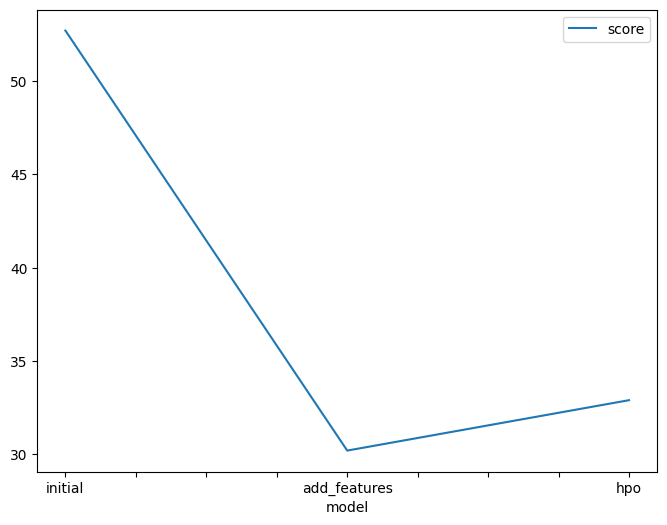

In [41]:
# Taking the top model score from each training run and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "model": ["initial", "add_features", "hpo"],
        "score": [52.7, 30.2, 32.9]
    }
).plot(x="model", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_train_score.png')

In [42]:
# Take the 3 kaggle scores and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo"],
        "score": [1.80, 0.72, 0.49]
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_test_score.png')

### Hyperparameter table

In [43]:
# The 3 hyperparameters tuned with the kaggle score as the result
pd.DataFrame({
    "model": ["initial", "add_features", "hpo"],
    "hpo1": ['default_values', 'default_values', 'GBM: num_leaves: lower=26, upper=66'],
    "hpo2": ['default_values', 'default_values', 'XGB: max_depth lower=5, upper=9'],
    "hpo3": ['default_values', 'default_values', "refit_full='best'"],
    "score": [1.80, 0.72, 0.49]
})

model                                 hpo1  \
0       initial                       default_values   
1  add_features                       default_values   
2           hpo  GBM: num_leaves: lower=26, upper=66   

                              hpo2               hpo3  score  
0                   default_values     default_values   1.80  
1                   default_values     default_values   0.72  
2  XGB: max_depth lower=5, upper=9  refit_full='best'   0.49